# Medical Entity Recognition

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Training Parameters

In [2]:
max_len = 50
char_max_len = 10
word_emb_size = 20
char_emb_size = 10
BATCH_SIZE = 512
EPOCHS = 100

## Load Data

In [3]:
# read the annotated dataset from kaggle
#data_files = ("CADEC.csv", "PubMed.csv", "Micromed.csv", "Twimed_Twitter.csv")
#data_df = (pd.read_csv(f) for f in data_files)
#data = pd.concat(data_df, axis=0, ignore_index=True)
data = pd.read_csv("CADEC.csv")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

chars = list(set([c for w in words for c in w]))
n_chars = len(chars)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

# Show the first 10 rows
data.head(n=10) 

Number of sentences:  7520
Number of words in the dataset:  8327
Tags: ['O', 'B-Disease', 'I-ADR', 'I-Drug', 'B-Symptom', 'I-Finding', 'B-Drug', 'I-Disease', 'B-ADR', 'I-Symptom', 'B-Finding']
Number of Labels:  11


,Document ID,Sentence #,Word,Tag
0,ARTHROTEC.1,0,I,O
1,ARTHROTEC.1,0,feel,O
2,ARTHROTEC.1,0,a,O
3,ARTHROTEC.1,0,bit,B-ADR
4,ARTHROTEC.1,0,drowsy,I-ADR
5,ARTHROTEC.1,0,&,O
6,ARTHROTEC.1,0,have,O
7,ARTHROTEC.1,0,a,O
8,ARTHROTEC.1,0,little,B-ADR
9,ARTHROTEC.1,0,blurred,I-ADR


In [4]:
data["Tag"].value_counts()

O            101896
I-ADR         10900
B-ADR          5756
B-Drug         1799
I-Finding       477
B-Finding       414
I-Symptom       332
B-Disease       282
B-Symptom       268
I-Drug          243
I-Disease       213
Name: Tag, dtype: int64

## Data Visualization

In [5]:
# A class to get the sentences from the dataset
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        aggregate_function = lambda s : [(w, t)
                                         for w, t in zip(s["Word"].values.tolist(),
                                                         s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(aggregate_function)
        self.sentences = [s for s in self.grouped]

    def getNext(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except Exception as e:
            print("Exception:", e)
            self.empty = True
            return None

(array([7.960e+02, 1.831e+03, 1.721e+03, 1.058e+03, 8.340e+02, 5.310e+02,
        2.360e+02, 1.720e+02, 1.140e+02, 6.600e+01, 4.800e+01, 3.200e+01,
        2.100e+01, 1.000e+01, 1.000e+01, 1.200e+01, 5.000e+00, 8.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1. ,   5.7,  10.4,  15.1,  19.8,  24.5,  29.2,  33.9,  38.6,
         43.3,  48. ,  52.7,  57.4,  62.1,  66.8,  71.5,  76.2,  80.9,
         85.6,  90.3,  95. ,  99.7, 104.4, 109.1, 113.8, 118.5, 123.2,
        127.9, 132.6, 137.3, 142. , 146.7, 151.4, 156.1, 160.8, 165.5,
        170.2, 174.9, 179.6, 184.3, 189. , 193.7, 198.4, 203.1, 207.8,
        212.5, 217.2,

Text(0.5, 1.0, 'Token per sentence')

Text(0.5, 0, 'Len (number of token)')

Text(0, 0.5, '# samples')

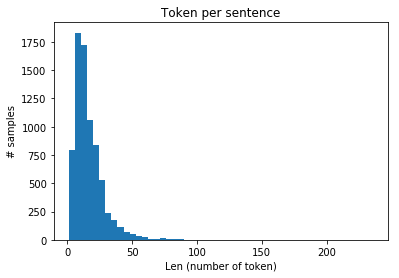

In [6]:
# Get all the sentences
sentence_getter = SentenceGetter(data)
l_sentences = sentence_getter.sentences
#l_sentences = []
#for s in sentences:
#    if len(s) <= max_len:
#        l_sentences.append(s)
#    else:
#        sent = ""
#        for w, t in s:
#            sent += w + ' '
#        print(sent, len(s))

# Plot sentence by lenght
plt.hist([len(s) for s in l_sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Data PreProcessing

In [7]:
# Prepare the data
words_to_index = {word: index + 2 for index, word in enumerate(words)}
words_to_index["UNK"] = 1
words_to_index["PAD"] = 0

char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["UNK"] = 1
char_to_index["PAD"] = 0

tags_to_index = {tag: index + 1 for index, tag in enumerate(tags)}
tags_to_index["PAD"] = 0

In [8]:
X_char = []
for sent in l_sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(char_max_len):
            try:
                word_seq.append(char_to_index[sent[i][0][j]])
            except:
                word_seq.append(char_to_index["PAD"])
        sent_seq.append(word_seq)
    X_char.append(sent_seq)

In [9]:
# preparing training and test data sets
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X = [[words_to_index[word[0]] for word in sentence] for sentence in l_sentences]
X = pad_sequences(maxlen=max_len, sequences=X, value=words_to_index["PAD"], padding="post", truncating='post')

y = [[tags_to_index[word[1]] for word in sentence] for sentence in l_sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tags_to_index["PAD"], padding="post", truncating='post')

# changing the y-labels to categorical for training purposes
y = [to_categorical(idx, num_classes=n_tags + 1) for idx in y]

# Split in Training and Test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=7777)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=7777)

idx = np.random.choice(range(len(l_sentences)))
print('Raw Sample: ', ' '.join([w[0] for w in l_sentences[idx]]))
print('Raw Label: ', ' '.join([w[1] for w in l_sentences[idx]]))
#print('After processing, sample:', X[77])
#print('After processing, labels:', y[77])

Raw Sample:  Experienced excruciating , unusual abdominal pain ( bowel , uterine ) and lower back pain for about 5 hours after taking ( including diarrhea 6 times ) , and heart palpitations and vaginal bleeding for about a day after taking 0
Raw Label:  O B-ADR I-ADR I-ADR I-ADR I-ADR O O O O O O B-ADR I-ADR I-ADR O O O O O O O O B-ADR O O O O O B-ADR I-ADR O B-ADR I-ADR O O O O O O O


## Model

In [11]:
# Now fitting a LSTM-CRF network with an embedding layer
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

model_input = Input(shape=(max_len,))
model = Embedding(input_dim = n_words + 2,
                  output_dim = word_emb_size,
                 input_length = max_len,
                  mask_zero = True)(model_input)  # 20-dim embedding#

model = Bidirectional(LSTM(units=50,
                           return_sequences=True,
                           recurrent_dropout=0.1))(model)     # variational biLSTM

model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer

crf = CRF(n_tags + 1) # CRF layer
out = crf(model)  # output

model = Model(model_input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()
#plot_model(model, to_file = 'lstm-crf.png')

history = model.fit(X_tr,
                    np.array(y_tr),
                    batch_size=512,
                    epochs=60,
                    validation_split=0.1,
                    verbose=1)
hist = pd.DataFrame(history.history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 20)            166580    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 100)           28400     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 50, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 50, 12)            780       
Total params: 200,810
Trainable params: 200,810
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Now fitting a LSTM-CRF network with an embedding layer
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, Conv1D, TimeDistributed, Bidirectional
from keras.layers import concatenate, SpatialDropout1D, Dropout, MaxPooling1D, Flatten
from keras.initializers import RandomUniform
from keras_contrib.layers import CRF
from keras.utils import plot_model

# Input and Embeddings for words
word_input = Input(shape=(max_len,))
word_emb = Embedding(input_dim = n_words + 2,
                     output_dim = word_emb_size,
                     input_length = max_len,
                     mask_zero = True)(word_input)  # 20-dim embedding#

# Input and Embeddings for characters
char_input = Input(shape=(max_len, char_max_len,))
char_emb = TimeDistributed(Embedding(input_dim = n_chars + 2,
                                     output_dim = char_emb_size,
                                     input_length = char_max_len,
                                     embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)))(char_input)  # 10-dim embedding#

char_dropout = Dropout(0.5)(char_emb)
char_conv = TimeDistributed(Conv1D(kernel_size = 3,
                                  filters = char_emb_size,
                                  padding = 'same',
                                  activation = 'tanh',
                                  strides = 1))(char_dropout)
char_maxpool = TimeDistributed(MaxPooling1D(char_max_len))(char_conv)
char_enc = TimeDistributed(Flatten())(char_maxpool)
char_enc = Dropout(0.5)(char_enc)


# Character LSTM to get word encodings by characters
#char_enc = TimeDistributed(LSTM(units = 20,
#                                return_sequences = False,
#                                recurrent_dropout = 0.5))(char_emb)

print(char_enc.shape, word_emb.shape)

# Main LSTM
x = concatenate([word_emb, char_enc])
x = SpatialDropout1D(0.3)(x)
model = Bidirectional(LSTM(units=50,
                           return_sequences=True,
                           recurrent_dropout=0.6))(x)     # variational biLSTM

model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer

crf = CRF(n_tags + 1) # CRF layer
out = crf(model)  # output

model = Model([word_input, char_input], out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()
#plot_model(model, to_file = 'cnn-lstm-crf.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


(?, 50, 10) (?, 50, 20)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 10)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 50, 10, 10)   930         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 10, 10)   0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 50, 10, 10)   310         dropout_1[0][0]                  
_____________________________________________________________________________________

## Training & Validation

In [175]:
history = model.fit([X_tr, np.array(X_char_tr).reshape((len(X_char_tr), max_len, char_max_len))],
                    np.array(y_tr),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1)

Train on 6091 samples, validate on 677 samples
Epoch 1/100
6091/6091 [==============================] - 11s 2ms/step - loss: 11.6181 - crf_viterbi_accuracy: 0.6744 - val_loss: 11.6269 - val_crf_viterbi_accuracy: 0.8346
Epoch 2/100
6091/6091 [==============================] - 4s 717us/step - loss: 10.8573 - crf_viterbi_accuracy: 0.8328 - val_loss: 11.4693 - val_crf_viterbi_accuracy: 0.8346
Epoch 3/100
6091/6091 [==============================] - 4s 714us/step - loss: 10.7537 - crf_viterbi_accuracy: 0.8328 - val_loss: 11.3973 - val_crf_viterbi_accuracy: 0.8346
Epoch 4/100
6091/6091 [==============================] - 4s 724us/step - loss: 10.6992 - crf_viterbi_accuracy: 0.8328 - val_loss: 11.3389 - val_crf_viterbi_accuracy: 0.8346
Epoch 5/100
6091/6091 [==============================] - 4s 717us/step - loss: 10.6500 - crf_viterbi_accuracy: 0.8328 - val_loss: 11.2884 - val_crf_viterbi_accuracy: 0.8346
Epoch 6/100
6091/6091 [==============================] - 4s 722us/step - loss: 10.6019 - 

Epoch 48/100
6091/6091 [==============================] - 4s 714us/step - loss: 10.1426 - crf_viterbi_accuracy: 0.9295 - val_loss: 10.8994 - val_crf_viterbi_accuracy: 0.9147
Epoch 49/100
6091/6091 [==============================] - 4s 717us/step - loss: 10.1373 - crf_viterbi_accuracy: 0.9330 - val_loss: 10.9184 - val_crf_viterbi_accuracy: 0.9104
Epoch 50/100
6091/6091 [==============================] - 4s 716us/step - loss: 10.1354 - crf_viterbi_accuracy: 0.9329 - val_loss: 10.9032 - val_crf_viterbi_accuracy: 0.9132
Epoch 51/100
6091/6091 [==============================] - 4s 720us/step - loss: 10.1340 - crf_viterbi_accuracy: 0.9321 - val_loss: 10.8969 - val_crf_viterbi_accuracy: 0.9128
Epoch 52/100
6091/6091 [==============================] - 4s 717us/step - loss: 10.1297 - crf_viterbi_accuracy: 0.9349 - val_loss: 10.8931 - val_crf_viterbi_accuracy: 0.9115
Epoch 53/100
6091/6091 [==============================] - 4s 713us/step - loss: 10.1282 - crf_viterbi_accuracy: 0.9361 - val_loss:

<Figure size 720x720 with 0 Axes>

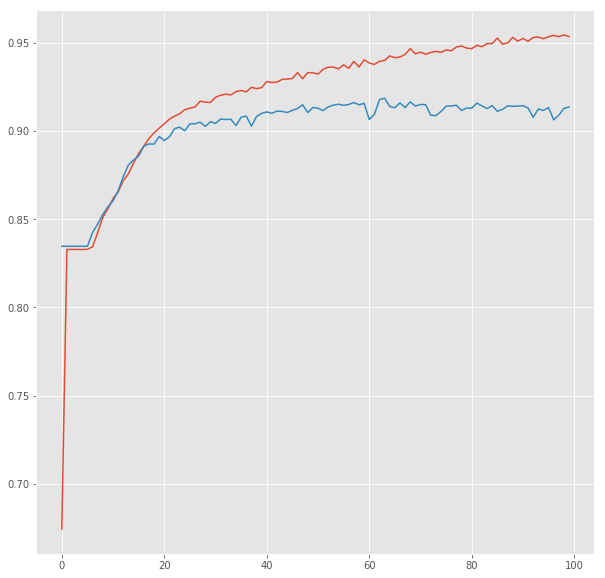

In [176]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

## Evaluation

In [177]:
# Evaluation
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

test_pred = model.predict([X_te, np.array(X_char_te).reshape((len(X_char_te), max_len, char_max_len))], 
                          verbose=1)
index_to_tags = {i: w for w, i in tags_to_index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(index_to_tags[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

752/752 [==============================] - 2s 3ms/step
F1-score: 61.6%
           precision    recall  f1-score   support

     Drug       0.91      0.86      0.89       169
  Disease       0.25      0.14      0.18        22
  Symptom       0.17      0.05      0.08        37
      ADR       0.61      0.60      0.60       618
  Finding       0.05      0.03      0.04        35

micro avg       0.64      0.59      0.62       881
macro avg       0.62      0.59      0.60       881



## Testing

In [574]:
# Trying some predictions
idx = np.random.choice(range(len(X_te)))
p = model.predict([np.array([X_te[idx]]), 
                   np.array([np.array(X_char_tr).reshape((len(X_char_tr), max_len, char_max_len))[idx]])])
p = pred2label(p)[0]
true = pred2label([y_te[idx]])[0]
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[idx], true, p):
    if w > 1:
        print("{:15}: {:5} {}".format(words[w-2], t, pred))

Word           ||True ||Pred
no             : O     O
side           : O     O
effects        : O     O
and            : O     O
it             : O     O
does           : O     O
its            : O     O
job            : O     O
0              : O     O


In [394]:
# Prediction on new sentence
test_sentence = ["I", "was", "suffering", "with", "chronicle", "headaches", "took",
                 "crocin", "for", "relieving", "pain"]
x_test_sent = pad_sequences(sequences=[[words_to_index.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}:{}".format("Word", "Prediction"))
print("="*26)
for w, pred in zip(test_sentence, p[0]):
    print("{:15}:  {:5}".format(w, l_tags[pred]))

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[7757, 8320, 3405, 7979,    0, 2232,  143,    0,  582,  904, 4464,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  ...